In [5]:
from sage.modules.free_module_integer import IntegerLattice
K=CyclotomicField(4)
Elt2Cord=K.gen().coordinates_in_terms_of_powers()
FP=RealField(128)
def SampleElt(q):
    return K.random_element(num_bound=q,den_bound=1,integral_coefficients=True,distribution='uniform')
def SampleIdeal(hamming):
    res=K.OK()
    for i in range(hamming):
        res=res*ideal_base[ZZ.random_element(len(ideal_base))]
    return res
def SampleModule(module_rank,q):
    ideal_list=[]
    vec_list=[]
    for i in range(module_rank*2):
        ideal_list.append(K.ideal(1))
    for i in range(module_rank):
        v=vector(K,module_rank*2)
        for j in range(module_rank):
            v[j]=SampleElt(q)
        v[module_rank+i]=1
        vec_list.append(v)
    for i in range(module_rank):
        v=vector(K,module_rank*2)
        v[i]=K(q)
        vec_list.append(v)
    return vec_list,ideal_list
def SampleModuleAjtai(module_rank,q):
    ideal_list=[]
    vec_list=[]
    for i in range(module_rank):
        ideal_list.append(K.ideal(1))
    v=vector(K,module_rank)
    v[0]=q
    vec_list.append(v)
    for i in range(1,module_rank):
        v=vector(K,module_rank)
        v[0]=SampleElt(q)
        v[i]=1
        vec_list.append(v)

    return vec_list,ideal_list
def Cord2Elt(cord):
    res=0
    for i in reversed(cord):
        res=res*K.gen()+i
    return res
def Cord2PseudoVec(cord):
    res=[]
    for i in range(0,len(cord),K.degree()):
        res.append(Cord2Elt(cord[i:i+K.degree()]))
def PseudoVec2Cord(vec):
    res=[]
    for i in vec:
        res+=Elt2Cord(i)
    return vector(res)

def dotKR(v1,v2):
    res=0
    assert len(v1)==len(v2)
    for i in range(len(v1)):
        res=res+v1[i]*v2[i].conjugate()
    return K(res)
def norm(v):
    return sqrt(dotKR(v,v).absolute_norm())
def Scale(vec,I):
    v=matrix(I.integral_basis())
    gram=dotKR(vec,vec)*(v.transpose()*v.conjugate())
    mat=[]
    for i in range(gram.dimensions()[0]):
        t=[]
        for j in range(gram.dimensions()[1]):
            t.append(gram[i,j].trace())
        mat.append(t)
    cord=matrix(mat).LLL_gram().transpose()[0]
    alpha=(matrix(cord)*v.transpose())[0,0]
    return alpha
def PseudoMat2ZMat(vec_list,ideal_list):
    #generate \oplus v_i I_i
    assert len(vec_list)==len(ideal_list)
    basis=[]
    submat=[]
    for i in range(len(vec_list)):
        B=ideal_list[i].integral_basis()    
        if len(B)<K.degree():
            B+=[K(0)]*(K.degree()-len(B))
        tmpmat=[]  
        for j in B:
            tmpmat.append(matrix(PseudoVec2Cord(vec_list[i]*j)))
        tmpmat=block_matrix(K.degree(),1,tmpmat)
        den=tmpmat.denominator()
        tmpmat=(den*tmpmat).change_ring(ZZ)
        mat,U=tmpmat.LLL(transformation=True)
        basis.append(U*vector(B)) 
        submat.append(mat/den) 
    return block_matrix(len(vec_list),1,submat),basis
def SolveEquation(vec_list,ideal_list,target_vec):
    assert len(vec_list)==len(ideal_list)

    target_vec_Z= vector(block_matrix(1,len(target_vec),[matrix(Elt2Cord(i)) for i in target_vec]))    
    

    mat,basis=PseudoMat2ZMat(vec_list,ideal_list)

    den_mat=mat.denominator()
    mat=(mat*den_mat).change_ring(ZZ)    
    B,U=mat.LLL(transformation=True)
    nz = sum(1 for r in B.rows() if r==0)   # number of zero rows in B
    B = B.delete_rows(range(nz))            # trimming first nz rows of B
    U = U.delete_rows(range(nz))            # trimming first nz rows of U
    L = IntegerLattice(B, lll_reduce=False)

    #print("Z_mat:")
    #print(mat)
    target_vec_Z=target_vec_Z*den_mat
    assert target_vec_Z in L
    cord_vec=L.coordinate_vector(target_vec_Z)*U
    ans=[]
    for i in range(len(vec_list)):
        ans.append(basis[i]*cord_vec[i*K.degree():(i+1)*K.degree()])
    return ans
def SolveEquation2(ideal_list,target_vec):
    vec_list=[vector([K(1)]) for i in range(len(ideal_list))]
    return SolveEquation(vec_list,ideal_list,target_vec)



In [6]:
def Transform(s,vec_list,ideal_list):
    assert len(vec_list)==len(ideal_list)
    assert len(vec_list)==2
    u,v=SolveEquation(vec_list,ideal_list,s)
    #print("u:",u,"v:",v)
    I1,I2=ideal_list
    #print("u cord:",I1.coordinates(u))
    #print("v cord:",I2.coordinates(v))
    if u.is_zero() or v.is_zero():
        if v.is_zero():
            print(norm(s),norm(vec_list[0])*ideal_list[0].absolute_norm())
            print("error: no progress!")
            return None
        if u.is_zero() and v.is_zero():
            print("error: zero vector!")
            return None
        else:
            #simple swap
            return [0,1,1,0],[I2,I1] 
    Iinv=u/I1+v/I2
    I=Iinv^-1
    x,y=SolveEquation2([v*I/I2,u*I/I1],vector([K(1)]))
    y=y/u 
    x=-x/v
    return [u,v,x,y],[I,I1*I2*Iinv]
def SVP_Oracle(vec_list,ideal_list):
    mat=PseudoMat2ZMat(vec_list,ideal_list)[0]
    den=mat.denominator()
    mat=(mat*den).change_ring(ZZ)
    #print(mat)
    mat=IntegerLattice(mat)
    s=(mat.shortest_vector()/den)
    #print(s*den)
    assert len(s)%K.degree()==0
    t=[]
    for i in range(0,len(s),K.degree()):
        t.append(Cord2Elt(s[i:i+K.degree()]))
    return vector(t)
def proj(v1,v2):
    return v1-(dotKR(v1,v2)/dotKR(v2,v2))*v2
def weak_size_reduce(vec_list,ideal_list):
    I1,I2=ideal_list
    if len(I1.gens())==1 and len(I2.gens())==1:
        b1,b2=vec_list
        a=I1.gens()[0]
        b=I2.gens()[0]
        rho=dotKR(b2,b1)/dotKR(b1,b1)*b/a
        rhoZ=vector(Elt2Cord(rho))
        k=Cord2Elt(list(map(round,rhoZ)))*a/b
        cord=(I1/I2).coordinates(k)
        for i in cord:
            assert i.is_integer()
        return k
    I=I1/I2
    b1,b2=vec_list
    rho=dotKR(b2,b1)/dotKR(b1,b1)
    mat=I.free_module().basis_matrix()
    den=mat.denominator()
    mat=(mat*den).change_ring(ZZ)
    mat=mat.LLL(delta=0.75)
    rhoZ=vector(Elt2Cord(rho))*den
    cord=vector([i.round() for i in mat.solve_left(rhoZ)])
    k=Cord2Elt(cord*mat)/den
    new_rho=dotKR(b2-k*b1,b1)/dotKR(b1,b1)
    for i in (I1/I2).coordinates(k):
        assert i.is_integer()
    return k

def CVP_Oracle(vec_list,ideal_list):
    #not use, qfminim can not work well in large coefficient case
    assert len(vec_list)==len(ideal_list)
    assert len(vec_list)==2
    b1,b2=vec_list
    I1,I2=ideal_list
    b2_star=proj(b2,b1)
    alpha2=dotKR(b1,b1)/dotKR(b2_star,b2_star)
    I=I1/I2
    v=matrix(I.integral_basis())
    gram=alpha2*(v.transpose()*v.conjugate())
    qd=[]
    mat=[]
    for i in range(K.degree()):
        t_v=[]
        for j in range(K.degree()):
            t_v.append(gram[i][j].trace())
        mat.append(t_v)
    mat=matrix(mat)
    den=mat.denominator()
    mat=(mat*den).change_ring(ZZ)
    U=mat.LLL_gram()
    mat=U.transpose()*mat*U 
    U=U.transpose()
    if mat.norm(Infinity)^2>=2^53:
        for i in range(K.degree()):
            for j in range(i,K.degree()):
                qd.append(round(mat[i][j]/den))
        if not QuadraticForm(ZZ,K.degree(),qd).is_positive_definite():
            b=1
            while not QuadraticForm(ZZ,K.degree(),qd).is_positive_definite():
                qd=[]
                for i in range(K.degree()):
                    for j in range(i,K.degree()):
                        qd.append(round(mat[i][j]*(2^b)/den))
                b+=1
            print(den,mat)
            

    else:
        for i in range(K.degree()):
            for j in range(i,K.degree()):
                qd.append(mat[i][j])

    qd=QuadraticForm(ZZ,K.degree(),qd)
    interface=qd.__pari__()
    tmp=interface.qfminim(flag=1,precision=256)[1]
    cord=matrix(list(map(int,tmp)))*U
    cord=(cord*v.transpose())[0,0]
    rho=dotKR(b2,b1)/dotKR(b1,b1)
    k=Elt2Cord(rho/cord)
    k=list(map(round,k))
    k=Cord2Elt(k)
    k=cord*k
    return k
def compute_GS(vec_list):
    res=[]
    for i in range(len(vec_list)):
        v=vec_list[i]
        for j in range(i):
            v=proj(v,res[j])
        res.append(v)
    return res
def profile(GS,ideal_list):
    return [log(FP(sqrt(dotKR(GS[i],GS[i]).absolute_norm())*ideal_list[i].absolute_norm()),2) for i in range(len(GS))]
def defect(vec_list,ideal_list):
    return [log(FP(sqrt(dotKR(vec_list[i],vec_list[i]).absolute_norm())*ideal_list[i].absolute_norm()),2) for i in range(len(vec_list))]
def gh(n):
    return (gamma(n/2+1)^(1/n)/sqrt(pi))
def check_integral(vec_list,ideal_list):
    for i in range(len(vec_list)):
        gens=ideal_list[i].gens_two()
        for j in vec_list[i]:
            if not (j*gens[0]).is_integral():
                return False
            if not (j*gens[1]).is_integral():
                return False
    return True
def compute_norm(vec_list,ideal_list):
    gs=compute_GS(vec_list)
    return prod([norm(i) for i in gs])*prod([i.absolute_norm() for i in ideal_list])
def ModuleLLL(vec_list,ideal_list,delta,debug=False):
    j=1
    ins_p=[0]*len(vec_list)
    iters=0
    d=K.degree()
    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
    norm_det=compute_norm(vec_list,ideal_list)
    #print("alphaK:",alphaK,(2^d)*abs(K.disc()))
    GS=compute_GS(vec_list)
    
    while j<len(vec_list):   
        pivot=j+1          
        iters+=1
        if iters%10==0:
            print("iters:",iters)
            print("ins_p:",ins_p)
            print("profile:",profile(GS,ideal_list))
        if debug:
            for i in vec_list:
                print(i)
            print(ideal_list)
        GS[j]=vec_list[j]
        ideal_norm=[i.absolute_norm() for i in ideal_list]
        assert check_integral(vec_list,ideal_list)
        assert norm_det==compute_norm(vec_list,ideal_list)
        for i in range(j):
            GS[j]=proj(GS[j],GS[i])
        for i in [j]:
            alpha=Scale(vec_list[i],ideal_list[i])
            ideal_list[i]/=alpha
            vec_list[i]*=alpha
            GS[i]*=alpha
        ideal_norm=[i.absolute_norm() for i in ideal_list]
        assert check_integral(vec_list,ideal_list)
        assert norm_det==compute_norm(vec_list,ideal_list)
        for i in [j]:
            cur=vec_list[i]
            for k in reversed(range(i)): 
                m=weak_size_reduce([GS[k],cur],[ideal_list[k],ideal_list[i]])   
                vec_list[i]=vec_list[i]-m*vec_list[k]
                cur=proj(cur-m*vec_list[k],GS[k])
        assert check_integral(vec_list,ideal_list)
        if debug:
            print("after:",vec_list[i])
            print("mu:")
            for i in range(len(vec_list)):
                cur=vec_list[i]
                mu=[]
                for k in reversed(range(i)): 
                    rho=dotKR(cur,GS[k])/dotKR(GS[k],GS[k]) 
                    mu.append(RDF((rho*rho.conjugate()).trace()))
                print(mu)
        if debug:
            print("vec_list after size reduce:")
            for i in vec_list:
                print(i)
            print("ideal_list after size reduce:",ideal_list)

        cur=vec_list[j] 
        for i in range(j):
            prev=cur
            cur=proj(cur,GS[i])
            #if delta*alphaK*norm(cur)*ideal_norm[j]<ideal_norm[i]*norm(GS[i]):
            if i==j-1: 
                #print("sub_module_vec:",sub_module_vec)
                #print("norms:",RDF(norm_v),RDF((norm_v/sqrt(K.degree()))^K.degree()),RDF(tmp_norm),RDF(ideal_norm[i]*norm(GS[i])))
                #print(tmp_norm,ideal_norm[i]*norm(GS[i]))
                if delta*alphaK*norm(GS[j])*ideal_norm[j]< ideal_norm[i]*norm(GS[i]):        
                    sub_module_vec=[GS[i],prev]
                    sub_module_ideal=[ideal_list[i],ideal_list[j]]
                    s=SVP_Oracle(sub_module_vec,sub_module_ideal)
                    tmp_norm=norm(s)
                    assert delta*tmp_norm<ideal_norm[i]*norm(GS[i])
                    U,new_ideal=Transform(s,sub_module_vec,sub_module_ideal)
                    u,v,x,y=U        
                    new_vec=[u*vec_list[i]+v*vec_list[j],x*vec_list[i]+y*vec_list[j]] 
                    assert check_integral(new_vec,new_ideal)
                    assert norm_det==compute_norm(vec_list,ideal_list)
                    vec_list.pop(j)
                    vec_list.pop(i)
                    ideal_list.pop(j)
                    ideal_list.pop(i)
                    ins_p[i]=ins_p[i]+1
                    vec_list.insert(i,new_vec[1])
                    vec_list.insert(i,new_vec[0])
                    ideal_list.insert(i,new_ideal[1])
                    ideal_list.insert(i,new_ideal[0])
                    ins_p[i]+=1
                    pivot=i

        j=pivot
    return sum(ins_p)
def ModuleDeepLLL(vec_list,ideal_list,delta,debug=False):
    j=1
    ins_p=[0]*len(vec_list)
    d=K.degree()
    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())

    iters=0    
    GS=compute_GS(vec_list)
    while j<len(vec_list):  
        iters+=1 
        if iters%10==0: 
            print("iters:",iters)
            print("profile:",profile(GS,ideal_list))  
            print("ins_p:",ins_p)
        pivot=j+1          
        #print("j:",j)
        #print("init:",profile(GS,ideal_list))
        if debug:
            for i in vec_list:
                print(i)
            print(ideal_list)
        GS[j]=vec_list[j]
        for i in range(j):
            GS[j]=proj(GS[j],GS[i])
        for i in [j]:
            alpha=Scale(vec_list[i],ideal_list[i])
            ideal_list[i]/=alpha
            vec_list[i]*=alpha
            GS[i]*=alpha
        ideal_norm=[i.absolute_norm() for i in ideal_list]
        check_integral(vec_list,ideal_list)
        for i in [j]:
            cur=vec_list[i]
            for k in reversed(range(i)): 
                m=weak_size_reduce([GS[k],cur],[ideal_list[k],ideal_list[i]])   
                vec_list[i]=vec_list[i]-m*vec_list[k]
                cur=proj(cur-m*vec_list[k],GS[k])
        check_integral(vec_list,ideal_list)
        if debug:
            print("after:",vec_list[i])
            print("mu:")
            for i in range(len(vec_list)):
                cur=vec_list[i]
                mu=[]
                for k in reversed(range(i)): 
                    rho=dotKR(cur,GS[k])/dotKR(GS[k],GS[k]) 
                    mu.append(RDF((rho*rho.conjugate()).trace()))
                print(mu)
        if debug:
            print("vec_list after size reduce:")
            for i in vec_list:
                print(i)
            print("ideal_list after size reduce:",ideal_list)

        cur=vec_list[j] 
        for i in range(j):
            prev=cur
            cur=proj(cur,GS[i])
            #if delta*alphaK*norm(cur)*ideal_norm[j]<ideal_norm[i]*norm(GS[i]):
            if delta*alphaK*norm(cur)*ideal_norm[j]< ideal_norm[i]*norm(GS[i]):                   
                sub_module_vec=[GS[i],prev]
                sub_module_ideal=[ideal_list[i],ideal_list[j]]
                s=SVP_Oracle(sub_module_vec,sub_module_ideal)
                tmp_norm=norm(s)
                U,new_ideal=Transform(s,sub_module_vec,sub_module_ideal)
                u,v,x,y=U        
                new_vec=[u*vec_list[i]+v*vec_list[j],x*vec_list[i]+y*vec_list[j]] 
                assert j>i
                vec_list.pop(j)
                vec_list.pop(i)
                ideal_list.pop(j)
                ideal_list.pop(i)

                ins_p[i]=ins_p[i]+1
                vec_list.insert(i,new_vec[1])
                vec_list.insert(i,new_vec[0])
                ideal_list.insert(i,new_ideal[1])
                ideal_list.insert(i,new_ideal[0])
     
                

                pivot=i
                break
        if debug:
            print("ideal:",ideal_list)
            #print("pivot:",pivot)
            #GS=compute_GS(vec_list)
            #print("after swap",profile(GS,ideal_list))        
     
        j=pivot
    return sum(ins_p)
def cal_root_hermite_factor(vec_list,ideal_list):
    n=len(vec_list)
    d=K.degree()
    gs=compute_GS(vec_list)
    norm_det=prod([norm(gs[i])*ideal_list[i].absolute_norm() for i in range(n)])
    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
    hermite_factor=norm(vec_list[0])*ideal_list[0].absolute_norm()/(norm_det^(1/n))
    hermite_factor=hermite_factor^(1/n)
    return FP((hermite_factor/alphaK)^(1/d))

def cal_root_defect(vec_list,ideal_list):
    n=len(vec_list)
    d=K.degree()
    gs=compute_GS(vec_list)
    norm_det=prod([norm(gs[i])*ideal_list[i].absolute_norm() for i in range(n)])    
    od=prod([norm(vec_list[i])*ideal_list[i].absolute_norm() for i in range(n)])/norm_det
    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
    betaK=od^(1/(module_rank*(module_rank-1)/2))
    return FP((betaK/alphaK)^(1/d))

def is_lll_reduced(vec_list,ideal_list,delta):
     alphaK=delta*(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
     gs=compute_GS(vec_list)
     for i in range(1,len(vec_list)):
        if delta*alphaK*norm(gs[i])*ideal_list[i].absolute_norm()<=norm(gs[i-1])*ideal_list[i-1].absolute_norm():
            print(RDF(norm(gs[i])*ideal_list[i].absolute_norm()))
            print(RDF(norm(gs[i-1])*ideal_list[i-1].absolute_norm()))
            print(RDF(delta*alphaK))
            return False
     return True
@parallel(10)
def one_test(deg,module_rank,seed):
    set_random_seed(seed)
    oracle_call=vector(ZZ,3)
    raw=[]
    d=K.degree()


    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
    delta_alphaK=alphaK*(4/3)
    lim= 2^(10*module_rank)
    q=random_prime(n=2*lim,lbound=lim)
    vec_list,ideal_list= SampleModuleAjtai(module_rank,q)   
    gs=compute_GS(vec_list)
    norm_det=prod([norm(gs[i])*ideal_list[i].absolute_norm() for i in range(module_rank)])
    assert norm_det==K(q).absolute_norm()
    t_vec=vec_list.copy()
    t_ideal=ideal_list.copy()
    print(seed)
    oracle_call[0]=ModuleLLL(vec_list,ideal_list,4/3)
    for i in vec_list:
        print(i)
        print(norm(i))
    print("root_factor:",cal_root_hermite_factor(vec_list,ideal_list))
    raw.append([norm(vec_list[i])*ideal_list[i].absolute_norm() for i in range(module_rank)])
    gs=compute_GS(vec_list)
    norm_det=prod([norm(gs[i])*ideal_list[i].absolute_norm() for i in range(module_rank)])
    assert norm_det==K(q).absolute_norm()

    oracle_call[2]=ModuleDeepLLL(vec_list,ideal_list,4/3)+oracle_call[0]
    raw.append([norm(vec_list[i])*ideal_list[i].absolute_norm() for i in range(module_rank)])
    gs=compute_GS(vec_list)
    norm_det=prod([norm(gs[i])*ideal_list[i].absolute_norm() for i in range(module_rank)])
    assert norm_det==K(q).absolute_norm()

    oracle_call[1]=ModuleDeepLLL(t_vec,t_ideal,4/3)
    raw.append([norm(t_vec[i])*t_ideal[i].absolute_norm() for i in range(module_rank)])
    gs=compute_GS(t_vec)
    norm_det=prod([norm(gs[i])*t_ideal[i].absolute_norm() for i in range(module_rank)])
    assert norm_det==K(q).absolute_norm()



    return norm_det,oracle_call,raw 


    






In [32]:
K=CyclotomicField(16)
Elt2Cord=K.gen().coordinates_in_terms_of_powers()
one_test(16,8,2)

2
iters: 10
ins_p: [6, 4, 0, 0, 0, 0, 0, 0]
profile: [246.71125810342323840717849998396917291, 201.71175784928023472805130886493755472, 159.45536395570879074971325211403312973, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000]
iters: 20
ins_p: [8, 8, 2, 0, 0, 0, 0, 0]
profile: [195.70764661803201524768233206915342350, 189.93436302812440060594454935873646994, 105.82552731301224989968040426067399493, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000]
iters: 30
ins_p: [12, 12, 4, 0, 0, 0, 0, 0]
profile: [178.11640272738692079924471041221932769, 173.58222266230991612958190202892593841, 139.25076820710124635288634287018975024, 102.02613761651053636677466649152931406, 0.00000000

(518080636117752727931239327532950354254511437647036842290459989439940169096567016623517347289916733679737548668545035407836230289339441604889914665339793632821990484595036708627691176489662590561,
 (124, 65, 133),
 [[1053452426039819919304612273313649455584,
   12931442329055481362737270706782070500796,
   789710278843752698589328627787718087791,
   15571722631873896309794495187651750940868,
   62300835852153576212959208262702895358609,
   3953198597999917046167347886656601086431,
   26439738860596986189933061989184736050001,
   1866362230483966899877208332488546746911],
  [751026795870860496484783977532740001,
   927831092366635339199978422537095261089,
   26898581937709250283739716814572416008,
   109626507933993601669437212190741749407,
   2565092570924105597130790572544588134724,
   166295351570473164700350795464013334271,
   481027730831623799971992777659570204656,
   58902316986732789633478557217995353152],
  [74786174424055787794947172119043920961,
   68246126758330246157240915

In [38]:
rep=10
#deg, module_rank
param=[]
for i in range(8,17):
    module_rank=8
    if is_prime_power(i):
        param.append((i,module_rank))
for deg,module_rank in param:
    params= [(deg,module_rank,i) for i in range(rep)]
    K=CyclotomicField(conductor)
    Elt2Cord=K.gen().coordinates_in_terms_of_powers()
   
    with open("raw_cyclo_"+str(conductor)+".txt", "w") as f:    
        ans=one_test(params)
        for _,res in ans:  
            det,call,raw=res
            f.write("det:"+str(det))
            f.write("\n")     
            f.write("call:"+str(call))
            f.write("\n")
            f.write("raw:"+str(raw))
            f.write("\n")

    


3
iters: 10
ins_p: [6, 4, 0, 0, 0, 0, 0, 0]
profile: [121.51298908648575077466296095973953904, 101.36117830891364923645378064143536872, 80.571352455725125684016654637271270412, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000]
iters: 20
ins_p: [8, 8, 2, 0, 0, 0, 0, 0]
profile: [94.479994783249585071935914345576801913, 95.910960695603096043825043434704015698, 52.962449306501022246096026029054492408, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000, 0.00000000000000000000000000000000000000]
iters: 30
ins_p: [12, 12, 4, 0, 0, 0, 0, 0]
profile: [86.142477308008183855021210819610497858, 85.198891937725080888615153798953070035, 71.391223039025540433860233185285054014, 52.910200191014743713068224225428672024, 0.00000000

<>:86: DeprecationWarning: invalid escape sequence '\g'
<>:86: DeprecationWarning: invalid escape sequence '\g'
/tmp/ipykernel_574010/3253949733.py:86: DeprecationWarning: invalid escape sequence '\g'
  plt.ylabel("$\gamma_{K}$")


(161.80000000000000000000000000000000000, 78.600000000000000000000000000000000000, 168.10000000000000000000000000000000000)
(0.48007858509537810937841076214340877392, 0.43875405134783915551015095682310346706, 0.43458128304609070215443826284456896820)
(0.61063291337608545743957540677019984545, 0.53222995803644124252508048030598726746, 0.51980068306704454068313313438098039398)
(154.00000000000000000000000000000000000, 83.800000000000000000000000000000000000, 160.20000000000000000000000000000000000)
(0.44336242629553079673904504899188184205, 0.42457855113845353957207789350085669539, 0.41295818325190545412693864300953227389)
(0.65310860443971878972096430348948175058, 0.58356723793771124867953763446694729275, 0.55804985767743268684544625038586248334)
(127.20000000000000000000000000000000000, 66.900000000000000000000000000000000000, 128.50000000000000000000000000000000000)
(0.36116821772448643112625293304567040811, 0.35373760366588542735906475528463268184, 0.346439879520967885860484503584560

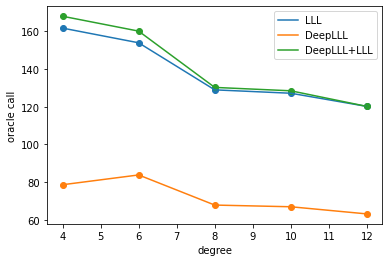

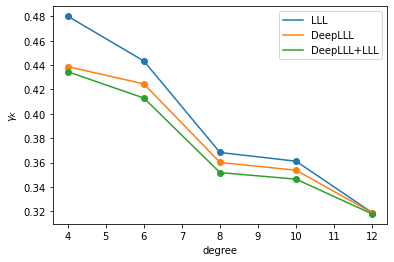

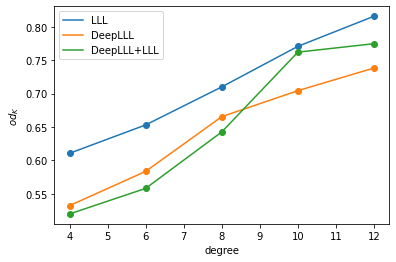

In [30]:
import matplotlib.pyplot as plt
import numpy as np
def compute_root_hermite_factor(norm_list,det,conductor):
    K=CyclotomicField(conductor)
    d=K.degree()
    n=len(norm_list[0])
    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
    res=vector(FP,3)
    for i in range(3):
        hermite_factor=norm_list[i][0]/(det^(1/n))
        hermite_factor=hermite_factor^(1/(n-1))
        res[i]=FP(hermite_factor/alphaK)^(1/d)
    return res

def compute_root_defect(norm_list,det,conductor):
    K=CyclotomicField(conductor)
    n=len(norm_list[0])
    d=K.degree()
    alphaK=(2*gh(2*d)/sqrt(d)) ^(2*d)* abs(K.disc())
    res=vector(FP,3)
    for i in range(3):  
        od=prod(norm_list[i])/norm_det
        betaK=od^(1/(n*(n-1)/2))
        res[i]=FP((betaK/alphaK)^(1/d))
    return res
oracle_call=[[],[],[]]
hermite_factor=[[],[],[]]
defect=[[],[],[]]
deg=[]
rep=10
for i in range(8,17):
    module_rank=8
    if is_prime_power(i):
        K=CyclotomicField(i)
        deg.append(K.degree())
        with open("raw_cyclo_"+str(i)+".txt", "r") as f:         
            a=vector(FP,3)
            b=vector(FP,3)
            c=vector(FP,3)
            for j in range(rep):
                norm_det=int(f.readline().split(':')[1])
                call=sage_eval(f.readline().split(':')[1])
                raw=sage_eval(f.readline().split(':')[1])
                a+=vector(call)
                b+=compute_root_hermite_factor(raw,norm_det,i)
                c+=compute_root_defect(raw,norm_det,i)
            a/=rep
            b/=rep
            c/=rep
            print(a)
            print(b)
            print(c)
            for i in range(3):
                oracle_call[i].append(a[i])
                hermite_factor[i].append(b[i])
                defect[i].append(c[i])
deg=np.array(deg,dtype=int)
ind=np.argsort(deg)
deg=deg[ind]
for i in range(3):
    oracle_call[i]=np.array(oracle_call[i])[ind]
    hermite_factor[i]=np.array(hermite_factor[i])[ind]
    defect[i]=np.array(defect[i])[ind]
plt.figure()
plt.plot(deg,oracle_call[0],label="LLL")
plt.plot(deg,oracle_call[1],label="DeepLLL")
plt.plot(deg,oracle_call[2],label="DeepLLL+LLL")
plt.scatter(deg,oracle_call[0])
plt.scatter(deg,oracle_call[1])
plt.scatter(deg,oracle_call[2])

plt.xlabel("degree")
plt.ylabel("oracle call")
plt.legend()
plt.savefig("oracle_call_cyclo.pdf")

plt.figure()
plt.plot(deg,hermite_factor[0],label="LLL")
plt.plot(deg,hermite_factor[1],label="DeepLLL")
plt.plot(deg,hermite_factor[2],label="DeepLLL+LLL")
plt.scatter(deg,hermite_factor[0])
plt.scatter(deg,hermite_factor[1])
plt.scatter(deg,hermite_factor[2])

plt.xlabel("degree")
plt.ylabel("$\gamma_{K}$")
plt.legend()
plt.savefig("root_hermite_cyclo.pdf")

plt.figure()
plt.plot(deg,defect[0],label="LLL")
plt.plot(deg,defect[1],label="DeepLLL")
plt.plot(deg,defect[2],label="DeepLLL+LLL")
plt.scatter(deg,defect[0])
plt.scatter(deg,defect[1])
plt.scatter(deg,defect[2])
plt.xlabel("degree")
plt.ylabel("$od_{K}$")
plt.legend()
plt.savefig("root_defect_cyclo.pdf")

